In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense1 = nn.Linear(4, 64)
        self.dense2 = nn.Linear(64, 128)
        self.dense3 = nn.Linear(128, 2)

        nn.init.kaiming_normal_(self.dense1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense2.weight, nonlinearity='relu')
        with torch.no_grad():
            self.dense3.weight *= 0.1

    def forward(self, x):
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = F.softmax(self.dense3(x), dim=1)
        return x

In [ ]:
import gymnasium as gym
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

EPISODES = 10000

env = gym.make("CartPole-v1", render_mode="rgb_array")

policy = Model()
optimizer = torch.optim.Adam(policy.parameters(), lr=1e-4)

discount = 0.99
losses = []
rewards = []
max_reward = 0

for e in range(EPISODES):
    observation, info = env.reset()

    steps = []

    episode_over = False
    running = 0
    while not episode_over:
        # frame = env.render()
        # clear_output(wait=True)
        # plt.imshow(frame)
        # plt.axis('off')
        # plt.show()
        # time.sleep(0.002)

        # action = env.action_space.sample()  # agent policy that uses the observation and info
        probs = policy(torch.from_numpy(observation).view(1, -1))
        action = torch.multinomial(probs, num_samples=1).item()
        observation, reward, terminated, truncated, info = env.step(action)

        steps.append((observation, action, reward))
        running += reward

        episode_over = terminated or truncated
    
    rewards.append(running)
    if running > max_reward:
        max_reward = running
        print(f"New max of {max_reward}")

    returns = []
    R = 0
    for _, _, r in reversed(steps):
        R = r + discount * R
        returns.insert(0, R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    loss = 0
    optimizer.zero_grad()
    for (s, a, _), R in zip(steps, returns):
        prob = policy(torch.from_numpy(s).view(1, -1))
        loss += -prob[0, a].log() * R

    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    losses.append(loss)

    if e % 500 == 0 and e > 0:
        print(f"Episodes {(e - 500, e)}: Avg Loss- {sum(losses[e-500:e])/500}, Avg Return- {sum(rewards[e-500:e])/len(rewards)}")
        
env.close()

New max of 69.0
Average Loss from Episodes 0: 0.02562105655670166
New max of 86.0
Average Loss from Episodes (0, 500): -0.4398626387119293
New max of 96.0
New max of 101.0
New max of 117.0
New max of 119.0
New max of 122.0
New max of 192.0
Average Loss from Episodes (500, 1000): -1.007058024406433
New max of 199.0
New max of 228.0
New max of 249.0
Average Loss from Episodes (1000, 1500): -1.9265271425247192
New max of 278.0
Average Loss from Episodes (1500, 2000): -4.745035171508789
New max of 321.0
New max of 340.0
New max of 367.0
New max of 399.0
New max of 462.0
New max of 469.0
Average Loss from Episodes (2000, 2500): -13.397629737854004
New max of 493.0
New max of 500.0
Average Loss from Episodes (2500, 3000): -27.868492126464844
Average Loss from Episodes (3000, 3500): -53.96236038208008
Average Loss from Episodes (3500, 4000): -42.89274215698242


KeyboardInterrupt: 

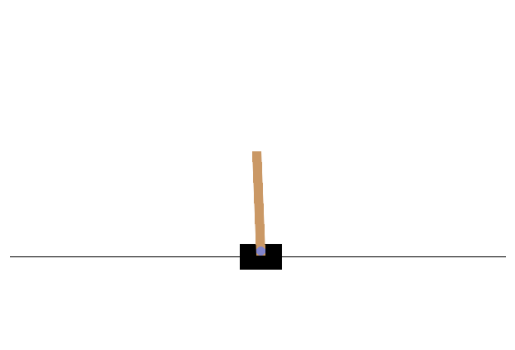

In [ ]:
observation, info = env.reset()

episode_over = False
running_R = 0
while not episode_over:
    frame = env.render()
    clear_output(wait=True)
    plt.imshow(frame)
    plt.axis('off')
    plt.show()
    time.sleep(0.002)

    action = env.action_space.sample()  # agent policy that uses the observation and info
    # probs = policy(torch.from_numpy(observation).view(-1, 4))
    # action = torch.multinomial(probs, num_samples=1).item()
    observation, reward, terminated, truncated, info = env.step(action)
    running_R += reward

    episode_over = terminated or truncated
        
env.close()

print(running_R)